# Austin Crime Project 

___

By: Alejandro Garcia, Matthew Luna, Kristofer Rivera, Oliver Ton
<br>
Date: June 2022


## Project Description

This project will dive into crime data from the city of Austin from 2018 to 2021. Having a deeper understanding of the crime in Austin will help improve public safety outcomes. This project will cover key indicators for successfully closing a case in Austin such as crime type, council district location, report time, and crime seasonality. Let’s keep Austin weird! And safe.

___

## Project Goals

Our goal for this project is to conduct exploratory data analysis into Austin crime data and use that analysis to create a machine learning model that can predict whether or not a case will be closed/cleared. We hope that this project will help guide policy making and the allocation of resources towards improving public safety outcomes in Austin. 

___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn, and sklearn installed on your computer.

___

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from prepare import split_data
from explore import *
from wrangle import *
from evaluate import *
from model import *

# Setting matplotlib/seaborn defaults
plt.rc('figure', figsize=(16, 8))
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['axes.axisbelow'] = True
plt.rc('font', size=16)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

The data set was gathered from publicly available data provided by the Austin Police Department on data.austintexas.gov. We created a function to automate gathering the data from the provided API and cache it locally as a CSV file. Our initial data set included 500,000 rows and 31 columns. For ease of use and relevancy, we decided to limit our data to crimes reported between the years 2018 and 2021. After removing data outside this time frame, we were left with 401,955 rows. 

## Data Preparation

After investigating columns with missing values, we decided to drop 15 columns entirely that we deemed to be unuseful or redundant. Next, we made decisions on how to handle the missing values in our remaining 16 columns. For 7 columns, including clearance_status, clearance_date, zip_code, sector, district, latitude, and longitude, we decided that we could not reasonably impute nulls with a value and dropped all missing rows. We had 753 missing values for location_type values which we decided to add to the Other / Unknown value. We had 1438 missing values for council_district which we decided to impute as the most common district. Next, we renamed four columns for readability. We then renamed the values in the clearance_status column with more descriptive values for clarity. Last, we ensured that our columns were using the appropriate data type. We changed latitude and longitude to float values and converted all of the date and time columns to a DateTime data type. After conducting all steps, we were left with 349,581 rows and 17 columns. 

In [2]:
# Use the wrangle module to aquire and prepare the data in one step.
df = wrangle_crime_data()

# Take a look the the dataframe
df.info()

Using cached csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436548
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   crime_type         349581 non-null  object         
 1   family_violence    349581 non-null  object         
 2   occurrence_time    349581 non-null  datetime64[ns] 
 3   occurrence_date    349581 non-null  datetime64[ns] 
 4   report_time        349581 non-null  datetime64[ns] 
 5   report_date        349581 non-null  datetime64[ns] 
 6   location_type      349581 non-null  object         
 7   address            349581 non-null  object         
 8   zip_code           349581 non-null  float64        
 9   council_district   349581 non-null  float64        
 10  sector             349581 non-null  object         
 11  district           349581 non-null  object         
 12  latitude           349581 non-null  float64        
 13  longitud

We'll also need to prepare our data separately for modeling. This will involve modifying the data into a form that can be used by the sklearn machine learning models.

In [3]:
# Use the model module to prepare a separate dataframe that will be used for modeling.
modeling_df = prep_data_for_modeling(df)

## Univariate Analysis

We plotted the distributions of all of our features to help guide our exploration. Most variables had normal or uniform distributions.
The most important takeaway from this analysis was that there is an imbalance in our target variable of clearance_status. We decided to make a new column to use as our target variable called cleared. This column combines 'cleared by arrest' and 'cleared by exception', creating a boolean value for whether or not a case is cleared. For the sake of maintaining data integrity, we decided to leave our imbalanced target variable as is and use either recall or precision as our performance metric in modeling. In a second iteration, we will try downsampling the data to create a more balanced target variable and see if that leads to any modeling performance improvements.

**Below is a histogram of our initial target variable.**

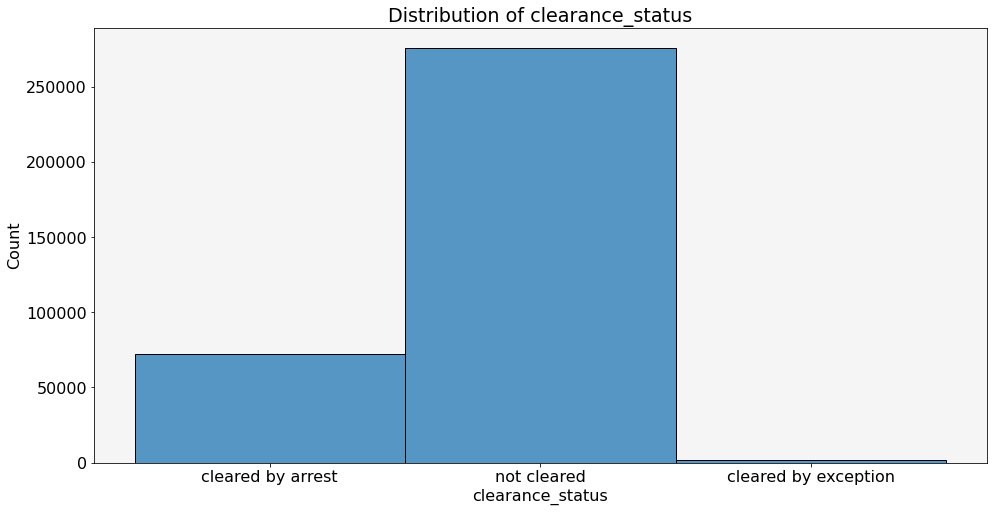

In [4]:
#Create a visual for the clearnance status 
plot_distribution(df, 'clearance_status')

**Below is the distribution of the new target variable after combining cleared by arrest and cleared by exception into one value.**

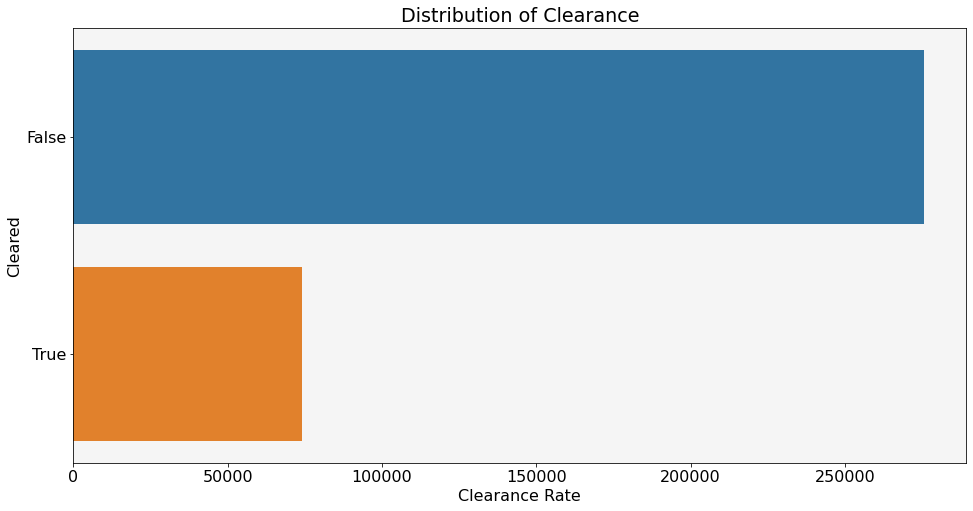

In [5]:
#Create a visual to visual the cleared  
plot_cleared(df)

## Splitting the Data

We split the data into a train, validate, and test sets to be used for exploration, modeling and evaluation. 

Our train set includes 50%, validate includes 30%, and test includes 20% of the data.

In [6]:
#Split the data
train, validate, test = split_data(df,'cleared')
#Check out the shape of train, validate and test
train.shape, validate.shape, test.shape

((195764, 19), (83900, 19), (69917, 19))

## Exploratory Analysis

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

*Setting confidence level at 95% which makes the alpha = .05 for statistical testing.*

### Question 1: Which types of crime are not getting solved/closed?

#### Statistical Testing

$H_0$: Type of crime and clearance are independent of eachother. 

$H_a$: Type of crime and and clearance are dependent on eachother.

In [7]:
#Performed a chi^2 test between the crime_type and the our target 
target = train.cleared
chi2(train.crime_type, target)

The chi2 value between the two variables is 103242.58074713743 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**A Chi^2 establishes that there is a statistically signifiant dependency.**

#### Visualizations

In [8]:
# Creating a subset of the data that only includes the top 10 crime types
top_crimes_df = subset_top_crimes(train)

*For the sake of visualization we created a subset of the train data frame that only includes the top 10 crimes.*

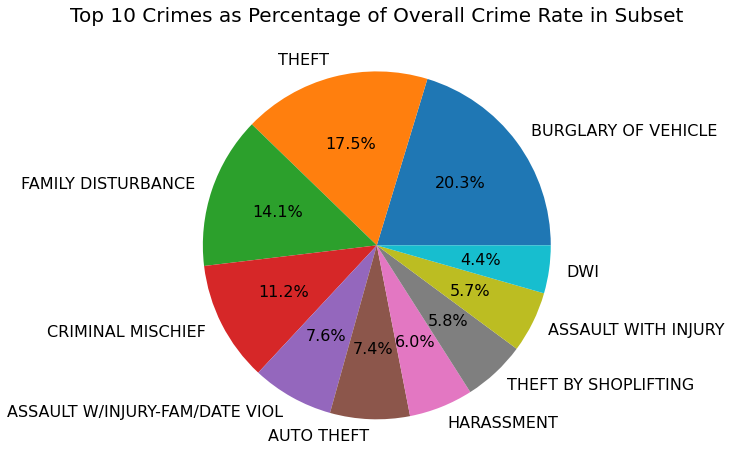

In [9]:
viz1(top_crimes_df)

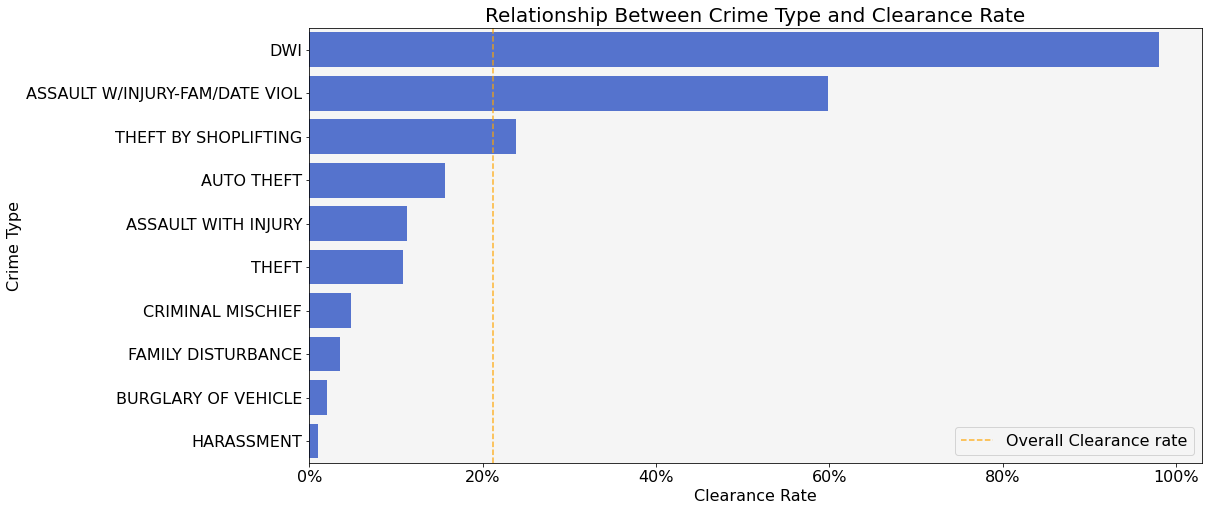

In [10]:
viz2(top_crimes_df, train)

#### Takeaways:

The overall case clearance rate is about 21%, but we have two crime types with clearance rates significantly above that, DWIs at 98% and Domestic Assault (assault bodily injury against a family member) at ~60%. While DWIs, are the least frequent type of crime reported amongst the top 10, they are the most likely crimes to be cleared. The three most frequent crime types (Burglary of Vehicle, Theft, and Family Disturbance) have some of the lowest case clearance rates. This imbalance of crime frequency and clearance rate likely accounts for the low overall clearance rate. Focusing resources towards improving clearance of these crimes would significantly improve overall case clearance.

### Question 2 - Are there certain city council districts with disproportionate levels of crime?

*For the sake of statistical testing and visualization, we created subsetted data frames that include the caseloads for all districts, district 9 and district 8.*

In [11]:
overall_sample, nine_sample, eight_sample = subset_districts(train)

#### Statistical Testing

$H_0$: The average caseload in District 9 is less than or equal to the average caseload of cases of all districts. 

$H_a$: The average caseload in District 9 is greater than the average caseload of cases of all districts.

*For the sake of statistical testing and visualization, we created subsetted data frames that include the caseloads for all districts, district 9 and district 8.*

In [12]:
t_test_1sample(nine_sample, overall_sample)

The t value between the two samples is inf and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value halved is less than the alpha, we reject the null hypothesis.


$H_0$: The average caseload in District 8 greater than or equal to the average caseload of cases of all districts.

$H_a$: The average caseload in District 8 is less than the average caseload of cases of all districts.

**A 1-sample t-test confirms our hypothesis that there is a statistically significant difference between the average caseload of district 9 and the overall caseload.**

In [13]:
t_test_1sample(eight_sample, overall_sample)

The t value between the two samples is -inf and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value halved is less than the alpha, we reject the null hypothesis.


**A 1-sample t-test confirms our hypothesis that there is a statistically significant difference between the average caseload of district 8 and the overall caseload.**

#### Visualizations

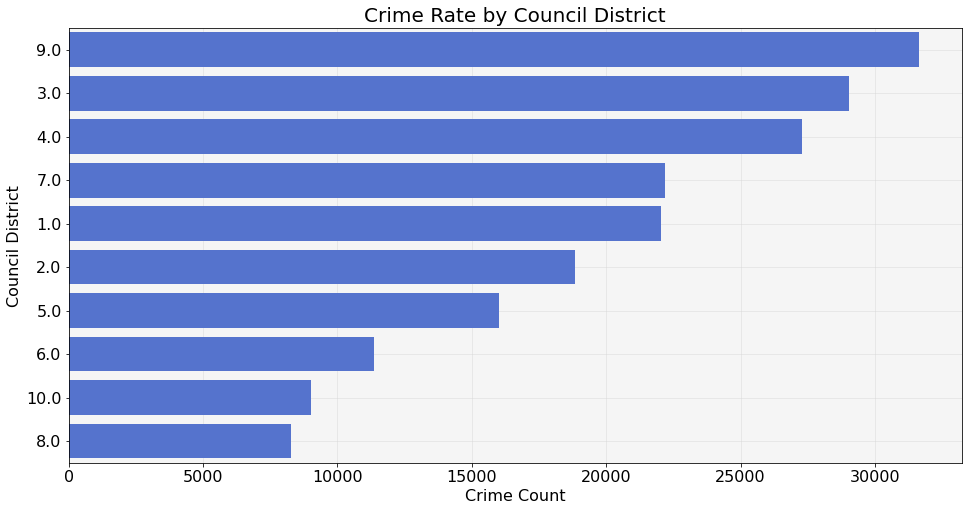

In [14]:
viz3(train)

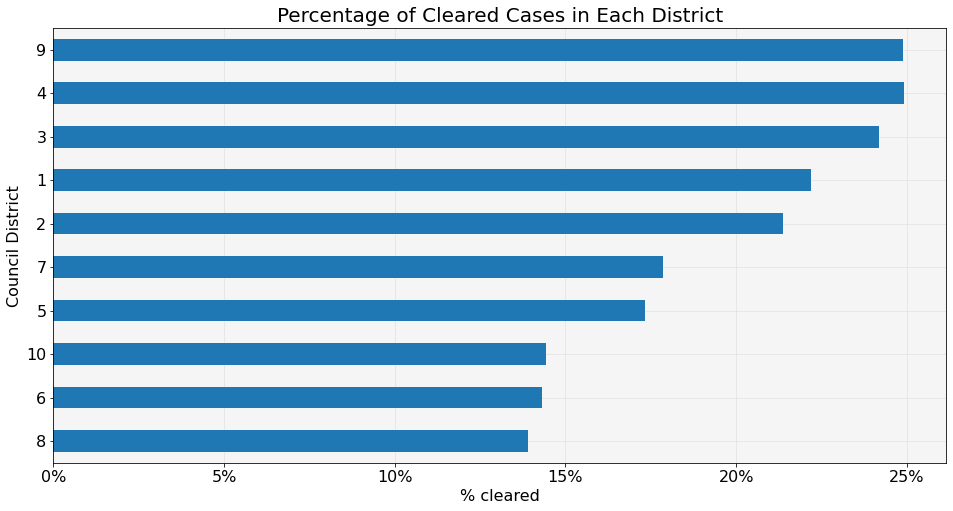

In [15]:
viz4(train)

#### Takeaways:

Our 2 highest council districts in terms of crime rate are 9 and 3 which makes sense considering they both consist of college campuses (Austin Community College and University of Texas at Austin) and the downtown area. The downtown area encompassed in districts 9 and 3 sees a high level of activity and nightlife with hotzones such as Rainey St, 6th St, Lady Bird Lake. The lowest council districts in terms of crime rate are 8 and 10 which consist of mainly residential areas and suburban communities. Percentage of cleared cases per district lines up very closely with the respective crime rate per district.

### Question 3 - Is crime seasonal? Are there times of the year when a crime is more prevalent? 

*For the sake of statistical testing and visualization, we created a seperate data frame that has been prepared for time-series analysis and subsets to compare crime levels between Friday and other days of the week.*

In [16]:
# Creating a seperate dataframe prepared for time-series analysis
time_series_df = time_series_df(train)
# Create subsets that include all days but Friday or only Friday for conducting a 1-sample t-test
subset_friday, subset_not_friday = friday_subsets(time_series_df)

#### Statistical Testing

$H_0$: There is no difference in crime levels between Fridays and other days of the week.

$H_a$: There is difference in crime levels between Fridays and other days of the week.

In [17]:
t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is -0.09923 and the P-Value is 0.9209589647466311.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


**An Independent t-test failed to reject the null hypothesis. We are not able to establish a statistically significant difference in crime rates between Fridays and other days of the week.**

#### Visualizations

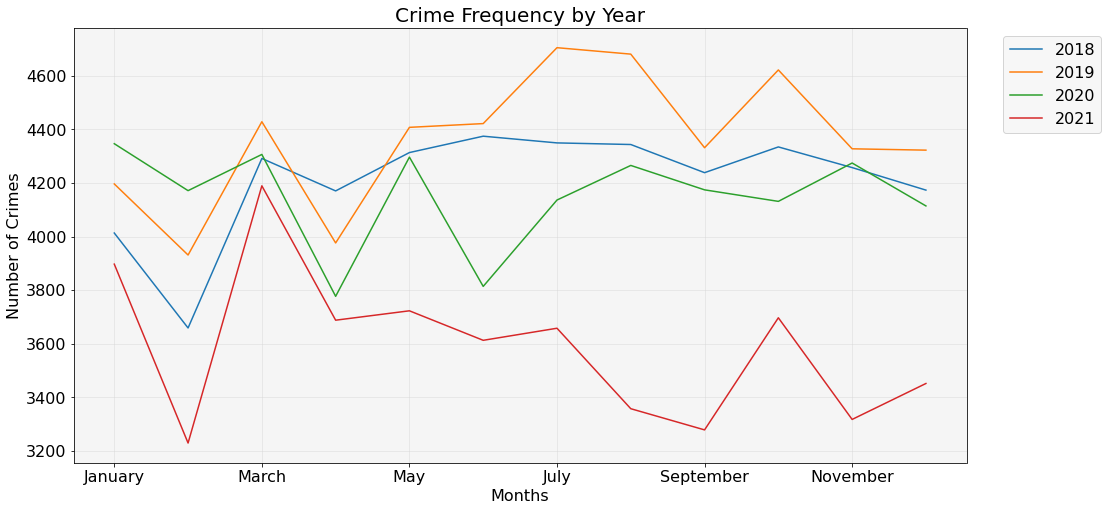

In [18]:
viz5(time_series_df)

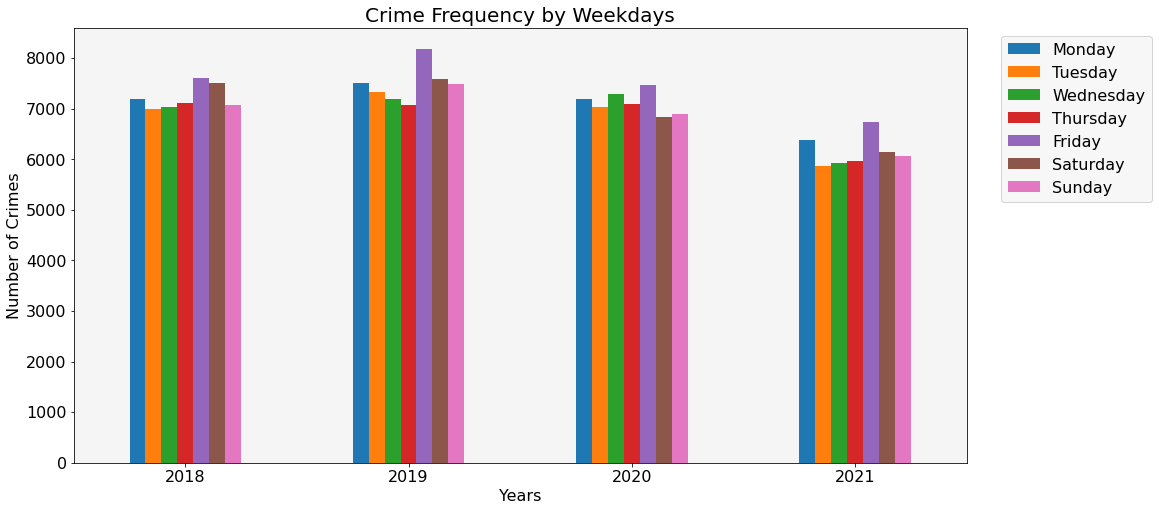

In [19]:
viz6(time_series_df)

#### Takeaways:

Our exploratory analysis shows a steady downward trend in crime since 2018. We see a significant spike in crime in March and in October which align with two large yearly events, South by Southwest and Austin City Limits. As would be expected, we see an exception to these spikes in 2020 when in-person events were cancelled due to the Covid-19 Pandemic. We generally see higher crime rates in the summer months compared to the winter months. On a weekly basis, we see consistently higher crime rates on Fridays though statistical testing was not able to confirm a statistically significant difference.

### Question 4 - Does the difference between time of incident and report time relate to a crime being solved/cleared?

*For the sake of statistical analysis and exploration, we needed to create a dataframe that with a calculated report_time feature and proper binning.*

In [20]:
report_time_df = report_time_df(train)

#### Statistical Testing

$H_0$: The clearance status of a case is independent of the difference in time between when a crime occurred and when it was reported.

$H_a$: The clearance status of a case is dependent on the difference in time between when a crime occurred and when it was reported.

In [21]:
chi2(report_time_df.time_to_report_bins, report_time_df.cleared)

The chi2 value between the two variables is 11868.361779948784 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**A chi^2 test allows us to reject the null hypothesis meaning that the clearance status of a case is dependent on the time to report the crime.**

*For robustness we also tested this using an independent t-test:*

$H_0$: The average number of cases cleared for cases with time to report less than 6 hours is equal to the average number of cases cleared for cases with time to report greater than 6 hours.

$H_a$: The average number of cases cleared for cases with time to report less than 6 hours is greater than the average number of cases cleared for cases with time to report greater than 6 hours.

In [22]:
time_to_report_less_than_24hrs = train.time_to_report <= pd.Timedelta('24h')
time_to_report_greater_than_24hrs = train.time_to_report > pd.Timedelta('24h')

t_test_ind(
    report_time_df[time_to_report_greater_than_24hrs].cleared,
    report_time_df[time_to_report_less_than_24hrs].cleared,
    alternative = 'greater'
)

The t value between the two samples is -112.4 and the P-Value is 1.0.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


**An independent t-test allows us to reject the null hypothesis meaning that cases with a time to report less than 6 hours have on average more cleared cases than cases with a time to report greater than 6 hours.**

#### Visualizations

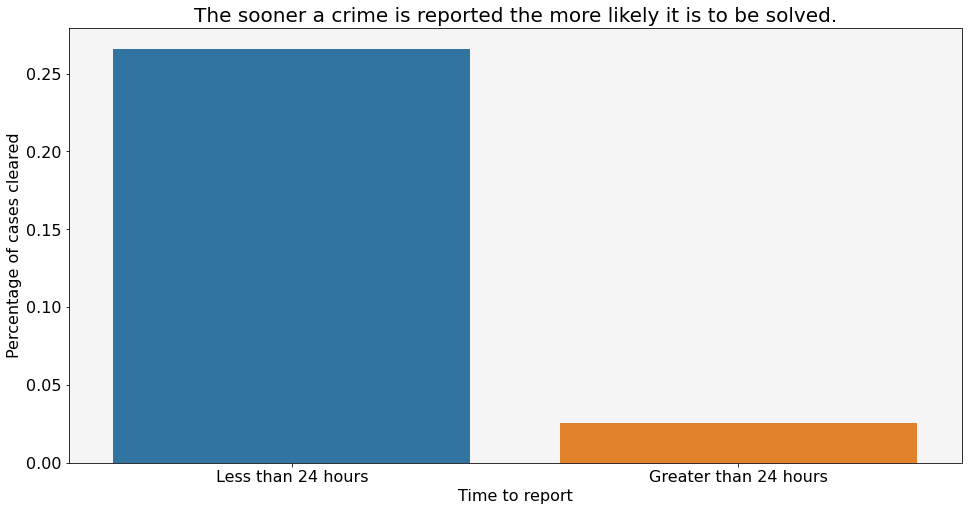

In [23]:
viz7(report_time_df)

#### Takeaways:

From the visualization we can determine that the clearance status of a case does depend on the amount time between when the crime occurred and when it was reported. Crimes that have no difference in occurance time and report time have significantly higher rates fo case clearance. When a crime is reported 6 hours or more after it has occurred there is a steep drop off in the case clerarance rate.

### Overall Takeaways from EDA

- Case clearance is statistically dependent on crime type. The top 3 most frequent crimes have some of the lowest clearance rates.
- Council districts that encompass the downtown and college campus areas have disproportionate levels of crime. 
- Crime in Austin is seasonal with higher levels in summer months versus the winter months and significant spikes during months where the city hosts large events.
- Crime clearance is dependent on how long it takes for the crime to be reported. There is a signifcant drop off in clearance rate if a crime is reported 6 hours or more after it has occured.

___

## Modeling

We are interested building a predictive model that is capable of predicting the clearance status of a case. To do this we'll build several classification models using the training dataset and evaluate on validate to determine how the models perform on unseen data.

We primarily used roc_auc score to compare the performance of our models with accuracy as a secondary performance measure. The roc_auc score allows us to determine how well a model predicts either value of the target variable whereas accuracy simply tells us the percentage of correct predictions the model had.

We'll first need to split our modeling dataframe into train, validate, and test.

In [24]:
train, validate, test = split_data(modeling_df, 'cleared')

### Establish a Baseline

We will need to establish a baseline model which will serve as performance reference for our models. The baseline will simply use the simplest approach to predict clearance status (which will be simply predicting the most frequent value). With this reference point will be able to determine if our models at least perform better than the simplest model we could build.

In [25]:
# Here we will establish a baseline model which will always predict the most frequent value in the target variable.

baseline = establish_classification_baseline(train.cleared)
baseline.value_counts()

False    195764
dtype: int64

The most frequent value for the target variable is False, meaning most cases are not cleared. This means the baseline model predicts only False. Now we'll see how this model performs.

In [26]:
eval_df = append_model_results('baseline', evaluate(train.cleared, baseline, True))
eval_df

,accuracy,roc_auc
baseline,0.79,0.5


The baseline model has an accuracy of 79%. This is because 79% of our observations are not cleared. The roc_auc score is a measure of how well the model makes predictions in general where the worst possible score is 0.5 and the best score is 1.0. The baseline model's roc_auc score is 0.5 meaning it is as good as random.

### Building Predictive Models

Now we will build a few predictive models to predict the clearance status of a case. The model.ipynb notebook contains the full process of building out predictive models we used. This involved building models using several different algorithms provided by sklearn. Here we'll only showcase the top performing models for conciseness.

In [27]:
# Here we'll build and train three models: a Bagging Classifier, an Ada Boost Classifier, and a Naive Bayes Classifier.

models = train_models(train)

In [28]:
# Here we'll evaluate our three models on the train set.

for model in models:
    eval_df = append_model_results(
        model,
        evaluate(train.cleared, models[model].make_predictions(train), True),
        eval_df
    )
    
eval_df.sort_values(by = 'roc_auc', ascending = False)

,accuracy,roc_auc
Bagging Classifier,0.97,0.95
Naive Bayes,0.89,0.81
Ada Boost,0.89,0.79
baseline,0.79,0.50


We can see here that on the train dataset the Bagging Classifier has the best performance, but we are more interested in knowing how well our models perform on unseen data so now we will evaluate them on the validate dataset.

In [29]:
# Here we'll evaluate our three models on the validate set.

eval_df = None

for model in models:
    eval_df = append_model_results(
        model,
        evaluate(validate.cleared, models[model].make_predictions(validate), True),
        eval_df
    )
    
eval_df.sort_values(by = 'roc_auc', ascending = False)

,accuracy,roc_auc
Bagging Classifier,0.89,0.81
Naive Bayes,0.89,0.81
Ada Boost,0.89,0.79


While the Bagging Classifier still has good performance on validate there is a large dropoff in performance between train and validate meaning the model is likely overfit. The next best performing model is the Naive Bayes Classifier which has an roc_auc score of 0.81 meaning it has good predictive ability in general. We'll now evaluate this model on the test dataset.

In [30]:
append_model_results(
    'Naive Bayes',
    evaluate(test.cleared, models['Naive Bayes'].make_predictions(test), True)
)

,accuracy,roc_auc
Naive Bayes,0.89,0.81


The Naive Bayes model is strangely consistent on unseen data, however all things considered there is no reason to believe that something has gone wrong so we will accept this model's performance.

With an accuracy of 89% this model is reasonably good at making predictions on the clearance status of case in general which could be potentially helpful in practice.

___

## Conclusion

Our exploratory data analysis provided several key insights surrounding the factors that drive crime and whether or not a case gets cleared. We identified that several of the top crimes in terms of frequency are also the lowest in terms of clearance rate. We identified disproportionate levels of crime in certain council districts. We see clear seasonal trends for crime and significant spikes in March and October coinciding with South by Southwest and Austin City Limits. Finally, we see the vital importance of timely reporting in ensuring a case gets cleared with a steep drop off when a crime is reported 6 hours after it has occured. Our best performing model was a Naive Bayes model that can predict case clearance with 89% accuraccy and a ROC-AUC score of .81. This accuracy score outperforms the baseline by ~11%.

___

## Recommendations

- We recommend increasing available manpower for the council districts with the highest levels of crime: 9, 3, 4
    - That said, we understanded that increased manpower is not the only solution to complex problem
- We recommend deterring crime by hardening targets. 
    - Encourage citizens to take protective measures against crime (i.e. having a dog in the yard, parking in well lit areas, not leaving valuables in plain view, etc.)
- We recommend encouraging citizens to be vigilant and to report crime or suspicious activity in a timely manner when they see it. 
    - Decreasing report time can significantly increase case clearance.

___

## Next Steps

With more time and on subsequent iterations of this project we hope to:

- Investigate the seasonality of crime types
- Further investigate the effects of the Covid-19 Pandemic on crime rate and case clerance
    - Has covid-19 increased rates of family violence?
- Use PD districts to evaluate the case clearing effectiveness of individual PD unitsEffects of covid on family violence. 
- Create visualizations and conduct geographic analysis of crime using Tableau